# PASHA: Efficient HPO with Progressive Resource Allocation

Hyperparameter optimization and neural architecture search are important for obtaining
well-performing models, but they are costly in practice, especially for large datasets.
To decrease the cost, practitioners adopt heuristics with mixed results. We propose an approach 
to tackle the challenge: start with a small amount of resources and progressively increase them
as needed. Our approach named PASHA measures the stability of ranking of different hyperparameter
configurations and stops increasing the resources if the ranking becomes stable, returning
the best configuration. Our experiments show PASHA significantly accelerates multi-fidelity methods
and obtains similarly well-performing hyperparameters.

Outline:
* Initial pre-processing and exploration
* Main experiments on NASBench201- with PASHA, ASHA and the baselines
* Alternative ranking functions
* Changes to the reduction factor
* Combination with Bayesian Optimization

Start by importing the relevant libraries:

In [1]:
import json
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import random

%matplotlib inline

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from benchmarking.blackbox_repository import load
from benchmarking.blackbox_repository.tabulated_benchmark import BlackboxRepositoryBackend
from benchmarking.definitions.definition_nasbench201 import nasbench201_benchmark, nasbench201_default_params
from syne_tune.backend.simulator_backend.simulator_callback import SimulatorCallback
from syne_tune.optimizer.schedulers.hyperband import HyperbandScheduler
from syne_tune.optimizer.baselines import baselines
from syne_tune.tuner import Tuner
from syne_tune.stopping_criterion import StoppingCriterion
from syne_tune.experiments import load_experiment


We will also need to use the `rbo` library for one of the additional ranking functions so install it now:

In [ ]:
! pip install rbo

Define our settings:

In [3]:
metric_valid_error_dim = 0
metric_runtime_dim = 2
dataset_names = ['cifar10', 'cifar100', 'ImageNet16-120']
epoch_names = ['val_acc_epoch_' + str(e) for e in range(200)]
random_seeds = [31415927, 0, 1234, 3458, 7685]
nb201_random_seeds = [0, 1, 2]
n_workers = 4

# Initial pre-processing and exploration

Load NASBench201 benchmark so that we can analyse the performance of various approaches:

In [4]:
bb_dict = load('nasbench201')
df_dict = {}

for seed in nb201_random_seeds:
    df_dict[seed] = {}
    for dataset in dataset_names:
        # create a dataframe with the validation accuracies for various epochs
        df_val_acc = pd.DataFrame((1.0-bb_dict[dataset].objectives_evaluations[:, seed, :, metric_valid_error_dim])
                                  * 100, columns=['val_acc_epoch_' + str(e) for e in range(200)])
        # add a new column with the best validation accuracy
        df_val_acc['val_acc_best'] = df_val_acc[epoch_names].max(axis=1)
        # create a dataframe with the hyperparameter values
        df_hp = bb_dict[dataset].hyperparameters
        # create a dataframe with the times it takes to run an epoch
        df_time = pd.DataFrame(bb_dict[dataset].objectives_evaluations[:, seed, :, metric_runtime_dim][:, -1], columns=['eval_time_epoch'])    
        # combine all smaller dataframes into one dataframe for each NASBench201 random seed and dataset
        df_dict[seed][dataset] = pd.concat([df_hp, df_val_acc, df_time], axis=1)


Motivation to measure best validation accuracy: NASBench201 provides validation and test errors in an inconsistent format and in fact we can only get the errors for each epoch on their combined validation and test sets for CIFAR-100 and ImageNet16-120. As a trade-off, we use the combined validation and test sets as the validation set. Consequently, there is no test set which we can use for additional evaluation and so we use the best validation accuracy as the final evaluation metric.

Have a look at what the dataframes look like:

In [5]:
df_dict[0]['cifar10']

,hp_x0,hp_x1,hp_x2,hp_x3,hp_x4,hp_x5,val_acc_epoch_0,val_acc_epoch_1,val_acc_epoch_2,val_acc_epoch_3,...,val_acc_epoch_192,val_acc_epoch_193,val_acc_epoch_194,val_acc_epoch_195,val_acc_epoch_196,val_acc_epoch_197,val_acc_epoch_198,val_acc_epoch_199,val_acc_best,eval_time_epoch
0,avg_pool_3x3,nor_conv_1x1,skip_connect,nor_conv_1x1,skip_connect,skip_connect,37.980003,36.909996,38.739998,31.059998,...,85.469994,85.479996,85.699997,85.689995,85.570000,85.639999,85.659996,85.619995,85.729996,15.461778
1,nor_conv_3x3,nor_conv_3x3,avg_pool_3x3,skip_connect,nor_conv_3x3,skip_connect,34.619999,61.129997,61.039997,70.029999,...,93.739998,93.739998,93.729996,93.709999,93.739998,93.729996,93.639999,93.750000,93.750000,23.198093
2,avg_pool_3x3,nor_conv_3x3,nor_conv_3x3,avg_pool_3x3,avg_pool_3x3,avg_pool_3x3,36.389999,44.279999,42.290001,42.139999,...,86.029999,85.790001,85.820000,85.959999,85.870003,85.699997,85.769997,85.839996,86.029999,24.261475
3,avg_pool_3x3,skip_connect,none,none,none,skip_connect,37.349998,48.919998,56.320000,59.029995,...,86.870003,86.779999,86.790001,86.830002,86.870003,86.720001,86.790001,86.809998,86.989998,9.305114
4,skip_connect,skip_connect,nor_conv_1x1,skip_connect,skip_connect,nor_conv_1x1,35.450001,36.369999,32.860001,34.069996,...,87.900002,88.199997,88.160004,88.099998,87.989998,88.070000,88.209999,88.090004,88.209999,13.933862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15620,none,avg_pool_3x3,avg_pool_3x3,skip_connect,skip_connect,none,40.399998,47.910000,58.350002,56.389999,...,86.449997,86.529999,86.489998,86.660004,86.639999,86.669998,86.559998,86.619995,86.669998,11.035928
15621,avg_pool_3x3,nor_conv_3x3,nor_conv_3x3,skip_connect,nor_conv_1x1,none,36.619995,51.030003,60.530003,45.649998,...,88.489998,88.459999,88.700005,88.610001,88.510002,88.510002,88.669998,88.400002,88.700005,22.097097
15622,skip_connect,nor_conv_3x3,nor_conv_3x3,nor_conv_3x3,none,nor_conv_1x1,37.989998,45.160000,48.240002,55.739998,...,92.779999,92.769997,92.809998,92.750000,92.720001,92.729996,92.769997,92.779999,92.849998,24.775816
15623,none,avg_pool_3x3,avg_pool_3x3,avg_pool_3x3,none,avg_pool_3x3,20.420002,29.619997,21.740002,25.230003,...,69.110001,68.739998,69.089996,69.330002,69.449997,69.459999,69.420006,69.480003,69.480003,14.217638


Perform brief exploratory analysis to show NAS is helpful:

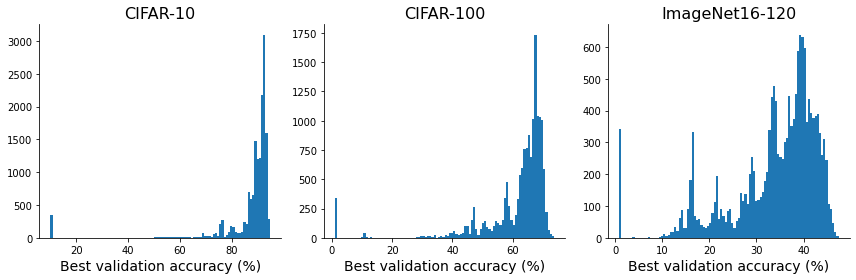

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.hist(df_dict[0]['cifar10']['val_acc_best'], bins=100)
plt.xlabel('Best validation accuracy (%)', fontsize=14)
plt.title('CIFAR-10', fontsize=16)

plt.subplot(132)
plt.hist(df_dict[0]['cifar100']['val_acc_best'], bins=100)
plt.xlabel('Best validation accuracy (%)', fontsize=14)
plt.title('CIFAR-100', fontsize=16)

plt.subplot(133)
plt.hist(df_dict[0]['ImageNet16-120']['val_acc_best'], bins=100)
plt.xlabel('Best validation accuracy (%)', fontsize=14)
plt.title('ImageNet16-120', fontsize=16)
plt.tight_layout()
plt.show()

We can clearly see that there is a huge difference between the various configurations, so NAS is important.

## Main experiments
We perform experiments on NASBench201 - CIFAR-10, CIFAR-100 and ImageNet16-120 datasets. We use PASHA, ASHA (promotion type) and the relevant baselines - one epoch and random.

Grace period is the name for minimum resources in SyneTune.

Define functions for running the experiments and analysing them:

In [7]:
def run_experiment(dataset_name, random_seed, nb201_random_seed, hpo_approach, reduction_factor=None, rung_system_kwargs={'ranking_criterion': 'soft_ranking', 'epsilon': 0.025}):
    """
    Function to run a NASBench201 experiment. It is similar to the NASBench201 example script
    in syne-tune but extended to make it simple to run our experiments.
    
    When describing the following parameters we say what values we use, but feel free to also use other values.
    
    :param dataset_name: one of 'cifar10', 'cifar100', 'ImageNet16-120'
    :param random_seed: one of 31415927, 0, 1234, 3458, 7685
    :param nb201_random_seed: one of 0, 1, 2
    :param hpo_approach: one of 'pasha', 'asha', 'pasha-bo', 'asha-bo'
    :param reduction_factor: by default None (resulting in using the default value 3) or 2, 4
    :param rung_system_kwargs: dictionary of ranking criterion (str) and epsilon or epsilon scaling (both float)
    :return: tuner.name
    
    """
    
    # this function is similar to the NASBench201 example script
    logging.getLogger().setLevel(logging.WARNING)

    default_params = nasbench201_default_params({'backend': 'simulated'})
    benchmark = nasbench201_benchmark(default_params)
    # benchmark must be tabulated to support simulation
    assert benchmark.get('supports_simulated', False)
    mode = benchmark['mode']
    metric = benchmark['metric']
    blackbox_name = benchmark.get('blackbox_name')
    # NASBench201 is a blackbox from the repository
    assert blackbox_name is not None

    config_space = benchmark['config_space']

    # simulator back-end specialized to tabulated blackboxes
    backend = BlackboxRepositoryBackend(
        blackbox_name=blackbox_name,
        elapsed_time_attr=benchmark['elapsed_time_attr'],
        time_this_resource_attr=benchmark.get('time_this_resource_attr'),
        dataset=dataset_name,
        seed=nb201_random_seed)

    # set logging of the simulator backend to WARNING level
    logging.getLogger('syne_tune.backend.simulator_backend.simulator_backend').setLevel(logging.WARNING)
    
    if not reduction_factor:
        reduction_factor = default_params['reduction_factor']

    # we support various schedulers within the function
    if hpo_approach == 'pasha':
        scheduler = baselines['PASHA'](
            config_space,
            max_t=default_params['max_resource_level'],
            grace_period=default_params['grace_period'],
            reduction_factor=reduction_factor,
            resource_attr=benchmark['resource_attr'],
            mode=mode,
            metric=metric,
            random_seed=random_seed,
            rung_system_kwargs=rung_system_kwargs)
    elif hpo_approach == 'asha':
        scheduler = baselines['ASHA'](
            config_space,
            max_t=default_params['max_resource_level'],
            grace_period=default_params['grace_period'],
            reduction_factor=reduction_factor,
            resource_attr=benchmark['resource_attr'],
            mode=mode,
            type='promotion',
            metric=metric,
            random_seed=random_seed)
    elif hpo_approach == 'pasha-bo':
        scheduler = HyperbandScheduler(
            config_space,
            max_t=default_params['max_resource_level'],
            grace_period=default_params['grace_period'],
            reduction_factor=reduction_factor,
            resource_attr=benchmark['resource_attr'],
            mode=mode,
            searcher='bayesopt',
            type='pasha',
            metric=metric,
            random_seed=random_seed,
            rung_system_kwargs=rung_system_kwargs)
    elif hpo_approach == 'asha-bo':
        scheduler = HyperbandScheduler(
            config_space,
            max_t=default_params['max_resource_level'],
            grace_period=default_params['grace_period'],
            reduction_factor=reduction_factor,
            resource_attr=benchmark['resource_attr'],
            mode=mode,
            searcher='bayesopt',
            type='promotion',
            metric=metric,
            random_seed=random_seed)
    else:
        raise ValueError('The selected scheduler is not implemented')

    stop_criterion = StoppingCriterion(max_num_trials_started=256)
    # printing the status during tuning takes a lot of time, and so does
    # storing results
    print_update_interval = 700
    results_update_interval = 300
    # it is important to set `sleep_time` to 0 here (mandatory for simulator
    # backend)

    tuner = Tuner(
        backend=backend,
        scheduler=scheduler,
        stop_criterion=stop_criterion,
        n_workers=n_workers,
        sleep_time=0,
        results_update_interval=results_update_interval,
        print_update_interval=print_update_interval,
        # this callback is required in order to make things work with the
        # simulator callback. It makes sure that results are stored with
        # simulated time (rather than real time), and that the time_keeper
        # is advanced properly whenever the tuner loop sleeps
        callbacks=[SimulatorCallback()],
    )
    
    tuner.run()
    
    return tuner.name

In [8]:
def analyse_experiments(experiment_names_dict, reference_time=None):
    """
    Function to analyse the experiments that we run with run_experiment function.
    
    :param experiment_names_dict: dictionary mapping the dataset names to tuples of
        experiment names and NASBench201 random seeds
    :reference_time: optional argument with the time it takes to run the standard method - e.g. ASHA
    :return: tuple of a line to display (string reporting the experiment results) and 
        the mean of the runtimes that can be used as reference time for other approaches
    """
    val_acc_best_list = []
    max_rsc_list = []
    runtime_list = []
    
    for experiment_name, nb201_random_seed in experiment_names_dict[dataset_name]:
        experiment_results = load_experiment(experiment_name)
        best_cfg = experiment_results.results['metric_valid_error'].argmin()
        
        # find the best validation accuracy of the corresponding entry in NASBench201
        table_hp_names = ['hp_x' + str(hp_idx) for hp_idx in range(6)]
        results_hp_names = ['config_hp_x' + str(hp_idx) for hp_idx in range(6)]
        condition = (df_dict[nb201_random_seed][dataset_name][table_hp_names] == experiment_results.results[results_hp_names].iloc[best_cfg].tolist()).all(axis=1)
        val_acc_best = df_dict[nb201_random_seed][dataset_name][condition]['val_acc_best'].values[0]  # there is only one item in the list
        val_acc_best_list.append(val_acc_best)
        max_rsc_list.append(experiment_results.results['hp_epoch'].max())
        runtime_list.append(experiment_results.results['st_tuner_time'].max())
        
    line = ' & {:.2f} $\pm$ {:.2f}'.format(np.mean(val_acc_best_list), np.std(val_acc_best_list))
    line += ' & {:.1f}h $\pm$ {:.1f}h'.format(np.mean(runtime_list)/3600, np.std(runtime_list)/3600)
    if reference_time:
        line += ' & {:.1f}x'.format(reference_time/np.mean(runtime_list))
    else:
        line += ' & {:.1f}x'.format(np.mean(runtime_list)/np.mean(runtime_list))
    line += ' & {:.1f} $\pm$ {:.1f}'.format(np.mean(max_rsc_list), np.std(max_rsc_list))
    
    return line, np.mean(runtime_list)

In [9]:
def compute_one_epoch_baseline():
    """
    Function to compute the performance of a simple one epoch baseline.
    :return: a line to display (string reporting the experiment results)
    """
    best_val_obj_list = []
    total_time_list = []
    
    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds:
            # randomly sample 256 configurations for the given dataset and NASBench201 seed
            # use the same seeds as for our other experiments
            random.seed(random_seed)
            cfg_list = random.sample(range(len(df_dict[nb201_random_seed][dataset_name])), 256)
            selected_subset = df_dict[nb201_random_seed][dataset_name].iloc[cfg_list]
            # find configuration with the best performance after doing one epoch
            max_idx = selected_subset['val_acc_epoch_0'].argmax()
            best_configuration = selected_subset.iloc[max_idx]
            # find the best validation accuracy of the selected configuration
            # as that is the metric that we compare 
            best_val_obj = best_configuration[epoch_names].max()

            # we also need to calculate the time it took for this
            # taking into account the number of workers
            total_time = selected_subset['eval_time_epoch'].sum() / n_workers

            best_val_obj_list.append(best_val_obj)
            total_time_list.append(total_time)

    line = ' & {:.2f} $\pm$ {:.2f}'.format(np.mean(best_val_obj_list), np.std(best_val_obj_list))
    line += ' & {:.1f}h $\pm$ {:.1f}h'.format(np.mean(total_time_list)/3600, np.std(total_time_list)/3600)
    line += ' & {:.1f}x'.format(reference_time/np.mean(total_time_list))
    line += ' & 1.0 $\pm$ 0.0'

    return line

In [10]:
def compute_random_baseline():
    """
    Function to compute the performance of a simple random configuration baseline.
    
    We consider a ten times larger number of configurations in this case to get a better
    estimate of the performance of a random configuration.

    :return: a line to display (string reporting the experiment results)
    """
    random.seed(0)
    random_seeds_rb = random.sample(range(999999), 256 * 10)

    best_val_obj_list = []
    total_time_list = []

    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds_rb:
            random.seed(random_seed)
            # select the random configurations
            cfg_list = random.sample(range(len(df_dict[nb201_random_seed][dataset_name])), 1)
            selected_configuration = df_dict[nb201_random_seed][dataset_name].iloc[cfg_list]
            # find the best validation accuracy of the selected configuration
            # as that is the metric that we compare 
            best_val_obj = selected_configuration[epoch_names].max()

            # we also need to calculate the time it took for this
            total_time = 0.0

            best_val_obj_list.append(best_val_obj)
            total_time_list.append(total_time)

    line = ' & {:.2f} $\pm$ {:.2f}'.format(np.mean(best_val_obj_list), np.std(best_val_obj_list))
    line += ' & {:.1f}h $\pm$ {:.1f}h'.format(np.mean(total_time_list)/3600, np.std(total_time_list)/3600)
    line += ' & NA'
    line += ' & 0.0 $\pm$ 0.0'

    return line

Run the main experiments with PASHA, ASHA and the baselines:

In [11]:
%%capture

experiment_names_pasha = {dataset: [] for dataset in dataset_names}
experiment_names_asha = {dataset: [] for dataset in dataset_names}

for dataset_name in dataset_names:
    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds:
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha')
            experiment_names_pasha[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'asha')
            experiment_names_asha[dataset_name].append((experiment_name, nb201_random_seed))


Analyse the experiments:

In [12]:
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments(experiment_names_asha)
    print('ASHA' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha, reference_time)
    print('PASHA' + result_summary)
    result_summary = compute_one_epoch_baseline()
    print('One epoch baseline', result_summary)
    result_summary = compute_random_baseline()
    print('Random baseline', result_summary)
    

cifar10
ASHA & 93.85 $\pm$ 0.25 & 3.0h $\pm$ 0.6h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 93.78 $\pm$ 0.31 & 2.3h $\pm$ 0.5h & 1.3x & 144.5 $\pm$ 59.4
One epoch baseline  & 93.30 $\pm$ 0.61 & 0.3h $\pm$ 0.0h & 8.5x & 1.0 $\pm$ 0.0
Random baseline  & 72.93 $\pm$ 19.55 & 0.0h $\pm$ 0.0h & NA & 0.0 $\pm$ 0.0
cifar100
ASHA & 71.69 $\pm$ 1.05 & 3.2h $\pm$ 0.9h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 71.41 $\pm$ 1.15 & 1.5h $\pm$ 0.7h & 2.1x & 88.3 $\pm$ 74.4
One epoch baseline  & 65.57 $\pm$ 5.53 & 0.3h $\pm$ 0.0h & 9.2x & 1.0 $\pm$ 0.0
Random baseline  & 42.98 $\pm$ 18.34 & 0.0h $\pm$ 0.0h & NA & 0.0 $\pm$ 0.0
ImageNet16-120
ASHA & 45.63 $\pm$ 0.81 & 8.8h $\pm$ 2.2h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 46.01 $\pm$ 1.00 & 3.2h $\pm$ 1.0h & 2.8x & 28.6 $\pm$ 27.7
One epoch baseline  & 41.42 $\pm$ 4.98 & 1.0h $\pm$ 0.0h & 8.8x & 1.0 $\pm$ 0.0
Random baseline  & 20.97 $\pm$ 10.01 & 0.0h $\pm$ 0.0h & NA & 0.0 $\pm$ 0.0


We see PASHA obtains a similar accuracy as ASHA, but it can find a well-performing configuration much faster.

The configurations found by one epoch baseline and random baseline usually obtain significantly lower accuracies, making them unsuitable for finding well-performing configurations.

## Alternative ranking functions
We evaluate a variety of ranking functions, which belong to different families:

1) Direct ranking where we strictly look at if the rankings are the same.

2) Soft ranking with $\epsilon$ selected from $[0.01, 0.02, 0.025, 0.03, 0.05]$ and variations of soft ranking with the value of $\epsilon$ estimated as a multiple of the standard deviation (multiple of 1, 2 and 3), mean distance or median distance between the values of the performance metric in the previous rung.

3) RBO score - we use $p=1.0$ and $p=0.5$ priorities for the top of the ranking (the former says all ranks have the same priority and the latter says that the top of the ranking has twice as large priority as the next one (similarly for the other ranks). We use minimum threshold value of $t=0.5$ to say if there is sufficient similarity between the rankings in the top two rungs.

4) RRR and ARRR scores (reciprocal rank regret and its absolute value variation) - we use $p=1.0$ and $p=0.5$ priorities for the top of the ranking (the former says all ranks have the same priority and the latter says that the top of the ranking has twice as large priority as the next one (similarly for the other ranks). We use maximum threshold value of $t=0.05$ to say if there is sufficient similarity between the rankings in the top two rungs.

In [13]:
%%capture

experiment_names_pasha_ranking = {dataset: [] for dataset in dataset_names}

experiment_names_pasha_e001 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_e002 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_e003 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_e005 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_std1 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_std2 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_std3 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_mean_dst = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_med_dst = {dataset: [] for dataset in dataset_names}

experiment_names_pasha_rbo_p1_t05 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_rbo_p05_t05 = {dataset: [] for dataset in dataset_names}

experiment_names_pasha_rrr_p1_t005 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_rrr_p05_t005 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_arrr_p1_t005 = {dataset: [] for dataset in dataset_names}
experiment_names_pasha_arrr_p05_t005 = {dataset: [] for dataset in dataset_names}

for dataset_name in dataset_names:
    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds:
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'ranking'})
            experiment_names_pasha_ranking[dataset_name].append((experiment_name, nb201_random_seed))
            
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'soft_ranking', 'epsilon': 0.01})
            experiment_names_pasha_e001[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'soft_ranking', 'epsilon': 0.02})
            experiment_names_pasha_e002[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'soft_ranking', 'epsilon': 0.03})
            experiment_names_pasha_e003[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'soft_ranking', 'epsilon': 0.05})
            experiment_names_pasha_e005[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'soft_ranking_std', 'epsilon_scaling': 1.0})
            experiment_names_pasha_std1[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'soft_ranking_std', 'epsilon_scaling': 2.0})
            experiment_names_pasha_std2[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'soft_ranking_std', 'epsilon_scaling': 3.0})
            experiment_names_pasha_std3[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'soft_ranking_mean_dst', 'epsilon_scaling': 1.0})
            experiment_names_pasha_mean_dst[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'soft_ranking_median_dst', 'epsilon_scaling': 1.0})
            experiment_names_pasha_med_dst[dataset_name].append((experiment_name, nb201_random_seed))
            
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'rbo', 'epsilon': 0.5, 'epsilon_scaling': 1.0})
            experiment_names_pasha_rbo_p1_t05[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'rbo', 'epsilon': 0.5, 'epsilon_scaling': 0.5})
            experiment_names_pasha_rbo_p05_t05[dataset_name].append((experiment_name, nb201_random_seed))

            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'rrr', 'epsilon': 0.05, 'epsilon_scaling': 1.0})
            experiment_names_pasha_rrr_p1_t005[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'rrr', 'epsilon': 0.05, 'epsilon_scaling': 0.5})
            experiment_names_pasha_rrr_p05_t005[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'arrr', 'epsilon': 0.05, 'epsilon_scaling': 1.0})
            experiment_names_pasha_arrr_p1_t005[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', rung_system_kwargs={'ranking_criterion': 'arrr', 'epsilon': 0.05, 'epsilon_scaling': 0.5})
            experiment_names_pasha_arrr_p05_t005[dataset_name].append((experiment_name, nb201_random_seed))

In [14]:
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments(experiment_names_asha)
    print('ASHA' + result_summary)
    
    result_summary, _ = analyse_experiments(experiment_names_pasha_ranking, reference_time)
    print('PASHA direct ranking' + result_summary)
    
    result_summary, _ = analyse_experiments(experiment_names_pasha_e001, reference_time)
    print('PASHA soft ranking $\epsilon=0.01$' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_e002, reference_time)
    print('PASHA soft ranking $\epsilon=0.02$' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha, reference_time)
    print('PASHA soft ranking $\epsilon=0.025$' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_e003, reference_time)
    print('PASHA soft ranking $\epsilon=0.03$' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_e005, reference_time)
    print('PASHA soft ranking $\epsilon=0.05$' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_std1, reference_time)
    print('PASHA soft ranking $1\sigma$' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_std2, reference_time)
    print('PASHA soft ranking $2\sigma$' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_std3, reference_time)
    print('PASHA soft ranking $3\sigma$' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_mean_dst, reference_time)
    print('PASHA soft ranking mean distance' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_med_dst, reference_time)
    print('PASHA soft ranking median distance' + result_summary)
    
    result_summary, _ = analyse_experiments(experiment_names_pasha_rbo_p1_t05, reference_time)
    print('PASHA RBO p=1.0, t=0.5' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_rbo_p05_t05, reference_time)
    print('PASHA RBO p=0.5, t=0.5' + result_summary)

    result_summary, _ = analyse_experiments(experiment_names_pasha_rrr_p1_t005, reference_time)
    print('PASHA RRR p=1.0, t=0.05' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_rrr_p05_t005, reference_time)
    print('PASHA RRR p=0.5, t=0.05' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_arrr_p1_t005, reference_time)
    print('PASHA ARRR p=1.0, t=0.05' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_arrr_p05_t005, reference_time)
    print('PASHA ARRR p=0.5, t=0.05' + result_summary)

cifar10
ASHA & 93.85 $\pm$ 0.25 & 3.0h $\pm$ 0.6h & 1.0x & 200.0 $\pm$ 0.0
PASHA direct ranking & 93.79 $\pm$ 0.26 & 2.7h $\pm$ 0.6h & 1.1x & 198.4 $\pm$ 6.0
PASHA soft ranking $\epsilon=0.01$ & 93.79 $\pm$ 0.26 & 2.6h $\pm$ 0.5h & 1.1x & 194.3 $\pm$ 21.2
PASHA soft ranking $\epsilon=0.02$ & 93.78 $\pm$ 0.31 & 2.4h $\pm$ 0.5h & 1.2x & 152.4 $\pm$ 58.3
PASHA soft ranking $\epsilon=0.025$ & 93.78 $\pm$ 0.31 & 2.3h $\pm$ 0.5h & 1.3x & 144.5 $\pm$ 59.4
PASHA soft ranking $\epsilon=0.03$ & 93.78 $\pm$ 0.32 & 2.2h $\pm$ 0.6h & 1.3x & 128.6 $\pm$ 58.3
PASHA soft ranking $\epsilon=0.05$ & 93.79 $\pm$ 0.49 & 1.8h $\pm$ 0.7h & 1.6x & 76.0 $\pm$ 66.0
PASHA soft ranking $1\sigma$ & 93.75 $\pm$ 0.32 & 2.4h $\pm$ 0.5h & 1.2x & 186.4 $\pm$ 35.2
PASHA soft ranking $2\sigma$ & 93.88 $\pm$ 0.28 & 1.9h $\pm$ 0.5h & 1.5x & 132.7 $\pm$ 68.7
PASHA soft ranking $3\sigma$ & 93.56 $\pm$ 0.69 & 0.9h $\pm$ 0.3h & 3.1x & 16.2 $\pm$ 19.9
PASHA soft ranking mean distance & 93.73 $\pm$ 0.52 & 2.3h $\pm$ 0.4h & 1.3x 

We see there are also other ranking functions that work well.

## Changes to the reduction factor

Reduction factor of 2:

In [15]:
%%capture

experiment_names_pasha_rf2 = {dataset: [] for dataset in dataset_names}
experiment_names_asha_rf2 = {dataset: [] for dataset in dataset_names}

for dataset_name in dataset_names:
    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds:
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', reduction_factor=2)
            experiment_names_pasha_rf2[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'asha', reduction_factor=2)
            experiment_names_asha_rf2[dataset_name].append((experiment_name, nb201_random_seed))

In [16]:
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments(experiment_names_asha_rf2)
    print('ASHA' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_rf2, reference_time)
    print('PASHA' + result_summary)
    

cifar10
ASHA & 93.88 $\pm$ 0.27 & 3.6h $\pm$ 1.1h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 93.77 $\pm$ 0.56 & 2.6h $\pm$ 0.6h & 1.4x & 134.9 $\pm$ 52.7
cifar100
ASHA & 71.67 $\pm$ 0.84 & 3.8h $\pm$ 1.0h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 71.79 $\pm$ 1.38 & 2.1h $\pm$ 0.7h & 1.8x & 101.5 $\pm$ 55.0
ImageNet16-120
ASHA & 46.09 $\pm$ 0.68 & 11.9h $\pm$ 4.0h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 45.72 $\pm$ 1.36 & 4.2h $\pm$ 1.7h & 2.8x & 49.5 $\pm$ 44.2


Reduction factor of 4:

In [17]:
%%capture

experiment_names_pasha_rf4 = {dataset: [] for dataset in dataset_names}
experiment_names_asha_rf4 = {dataset: [] for dataset in dataset_names}

for dataset_name in dataset_names:
    for nb201_random_seed in nb201_random_seeds:
        for random_seed in random_seeds:
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha', reduction_factor=4)
            experiment_names_pasha_rf4[dataset_name].append((experiment_name, nb201_random_seed))
            experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'asha', reduction_factor=4)
            experiment_names_asha_rf4[dataset_name].append((experiment_name, nb201_random_seed))

In [18]:
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments(experiment_names_asha_rf4)
    print('ASHA' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_rf4, reference_time)
    print('PASHA' + result_summary)
    

cifar10
ASHA & 93.75 $\pm$ 0.28 & 2.4h $\pm$ 0.6h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 93.72 $\pm$ 0.30 & 2.1h $\pm$ 0.5h & 1.2x & 154.7 $\pm$ 64.1
cifar100
ASHA & 71.43 $\pm$ 1.13 & 2.7h $\pm$ 0.9h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 71.76 $\pm$ 1.20 & 1.1h $\pm$ 0.5h & 2.4x & 59.2 $\pm$ 74.8
ImageNet16-120
ASHA & 45.43 $\pm$ 0.98 & 7.9h $\pm$ 3.0h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 45.48 $\pm$ 1.36 & 3.2h $\pm$ 1.7h & 2.4x & 40.3 $\pm$ 49.8


PASHA leads to significant speedup for both reduction factors.

## Combination with Bayesian Optimization
We explore if PASHA can be successfully combined with more complex search strategies based on Bayesian Optimization.

These experiments take longer to run so we need to run them separately using a script that can be run in a distributed way across many nodes (we still use the simulator backend but Gaussian processes take some time to run to estimate the best parameters). We provide a script called `run_bo_experiments.py` that can run such experiments (the script accepts arguments such as the random seed selected).

In [19]:
# need to load the names of the configurations from the json file where we store it
with open('bo_experiment_details.json', 'r') as f:
    bo_experiment_details = json.load(f)

experiment_names_pasha_bo = {dataset: [] for dataset in dataset_names}
experiment_names_asha_bo = {dataset: [] for dataset in dataset_names}

# load the details of the experiments
for detail_dict in bo_experiment_details:
    if detail_dict['scheduler'] == 'asha-bo':
        experiment_names_asha_bo[detail_dict['dataset_name']].append((detail_dict['experiment_name'], detail_dict['nb201_random_seed']))
    elif detail_dict['scheduler'] == 'pasha-bo':
        experiment_names_pasha_bo[detail_dict['dataset_name']].append((detail_dict['experiment_name'], detail_dict['nb201_random_seed']))


In [20]:
for dataset_name in dataset_names:
    print(dataset_name)
    result_summary, reference_time = analyse_experiments(experiment_names_asha_bo)
    print('ASHA' + result_summary)
    result_summary, _ = analyse_experiments(experiment_names_pasha_bo, reference_time)
    print('PASHA' + result_summary)
    

cifar10
ASHA & 94.10 $\pm$ 0.22 & 5.0h $\pm$ 1.3h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 94.17 $\pm$ 0.17 & 4.4h $\pm$ 1.7h & 1.1x & 156.7 $\pm$ 62.4
cifar100
ASHA & 72.76 $\pm$ 0.64 & 5.6h $\pm$ 2.0h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 72.07 $\pm$ 1.80 & 3.8h $\pm$ 1.7h & 1.5x & 157.9 $\pm$ 72.7
ImageNet16-120
ASHA & 45.79 $\pm$ 1.18 & 13.8h $\pm$ 5.0h & 1.0x & 200.0 $\pm$ 0.0
PASHA & 45.02 $\pm$ 1.15 & 6.2h $\pm$ 5.8h & 2.2x & 50.0 $\pm$ 75.4


Alternative would be to run the following two cells (uncommented) but it would take several hours to run the first one.

In [21]:
# %%capture

# experiment_names_pasha_bo = {dataset: [] for dataset in dataset_names}
# experiment_names_asha_bo = {dataset: [] for dataset in dataset_names}

# for dataset_name in dataset_names:
#     for nb201_random_seed in nb201_random_seeds:
#         for random_seed in random_seeds:
#             experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'pasha-bo')
#             experiment_names_pasha_bo[dataset_name].append((experiment_name, nb201_random_seed))
#             experiment_name = run_experiment(dataset_name, random_seed, nb201_random_seed, 'asha-bo')
#             experiment_names_asha_bo[dataset_name].append((experiment_name, nb201_random_seed))

In [22]:
# for dataset_name in dataset_names:
#     print(dataset_name)
#     result_summary, reference_time = analyse_experiments(experiment_names_asha_bo)
#     print('ASHA' + result_summary)
#     result_summary, _ = analyse_experiments(experiment_names_pasha_bo, reference_time)
#     print('PASHA' + result_summary)
    

To generate the lists of configurations for a slurm script and easily use the `run_bo_experiments.py`, you can run the following:

In [23]:
# # we need to generate the lists with values to use
# dataset_names = ['cifar10', 'cifar100', 'ImageNet16-120']
# approaches = ['pasha-bo', 'asha-bo']
# random_seeds = [31415927, 0, 1234, 3458, 7685]
# nb201_random_seeds = [0, 1, 2]

# dataset_names_list = []
# approaches_list = []
# random_seeds_list = []
# nb201_random_seeds_list = []

# for dataset_name in dataset_names:
#     for nb201_random_seed in nb201_random_seeds:
#         for random_seed in random_seeds:
#             for approach in approaches:
#                 dataset_names_list.append(dataset_name)
#                 approaches_list.append(approach)
#                 random_seeds_list.append(random_seed)
#                 nb201_random_seeds_list.append(nb201_random_seed)
    
# print('DATASET_NAME=(')
# for dataset_name in dataset_names_list:
#     print(dataset_name)
# print(')')
# print()

# print('APPROACH=(')
# for approach in approaches_list:
#     print(approach)
# print(')')
# print()

# print('RANDOM_SEED=(')
# for random_seed in random_seeds_list:
#     print(random_seed)
# print(')')
# print()

# print('NB201_RANDOM_SEED=(')
# for nb201_random_seed in nb201_random_seeds_list:
#     print(nb201_random_seed)
# print(')')
# print()